In [1]:
# before this tutorial, please read Visualize_deep_features.ipynb first
# 
# we use pretrained vgg19 in this script
# so download model file 'vgg19.pth' by url:
# https://download.pytorch.org/models/vgg19-dcbb9e9d.pth
# 
# and place it in project directory

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from Sequence import Sequence
from matplotlib.patches import Rectangle
from skimage import io,transform
import os
import torch
from torch.autograd import Variable
import vgg
import utils
from scipy import ndimage

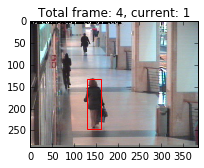

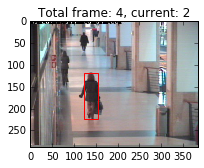

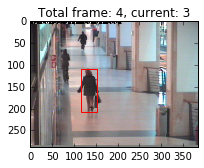

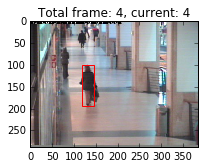

In [2]:
# Visualize Sequence 

sequence = Sequence(path = os.getcwd(), name='tutorials/img_ScaleChange', 
                    region_format='rectangle')
plt.clf()

while sequence._frame < len(sequence._images):
    
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    plt.figure(figsize=(3,3))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence

In [3]:
# init

padding = 1.5
lamda = 1e-4
output_sigma_factor = 0.1
interp_factor = 0.01  
cell_size = 4
scaling=1
scale_factors = [1.0, 1.02, 0.98]

img_raw = io.imread(sequence.frame()) 

data = sequence.groundtruth[sequence._frame]
X = data.x
Y = data.y
width = data.width
height = data.height
target_size = [height, width]
target_size = np.array(target_size)
pos = [Y+height/2.,X+width/2.]

base_target_size = target_size
sz = np.floor(base_target_size * (1 + padding))
l1_patch_num = np.floor(sz / cell_size)

# Gaussian shaped label for location
output_sigma = np.sqrt(np.prod(target_size)) * output_sigma_factor/cell_size
grid_y = np.arange(np.floor(l1_patch_num[0])) - np.floor(l1_patch_num[0]/2)
grid_x = np.arange(np.floor(l1_patch_num[1])) - np.floor(l1_patch_num[1]/2)
rs, cs = np.meshgrid(grid_x, grid_y)
y = np.exp(-0.5 / output_sigma ** 2 * (rs ** 2 + cs ** 2))

yf = np.fft.fft2(y, axes=(0,1))

cos_window = np.outer(np.hanning(yf.shape[0]), np.hanning(yf.shape[1]))

In [4]:
# network init

model = vgg.VGG_19(outputlayer=[17])

# load partial weights
model_dict = model.state_dict()
params = torch.load('vgg19.pth')
load_dict = {k:v for k,v in params.items() if 'features' in k}
model_dict.update(load_dict)
model.load_state_dict(model_dict)

# extract features

imgMean = np.array([0.485, 0.456, 0.406], np.float)
imgStd = np.array([0.229,0.224,0.225])
img = utils.get_subwindow(img_raw, pos, sz)
img = transform.resize(img,(224,224))
img = (img-imgMean)/imgStd
img = np.transpose(img, (2,0,1))
feature = model(Variable(torch.from_numpy(img[None,:,:,:]).float()))
feature = feature[0].data[0].numpy().transpose((1, 2, 0))
x = ndimage.zoom(feature, (float(cos_window.shape[0])/feature.shape[0],
                           float(cos_window.shape[1])/feature.shape[1], 1), order=1)
x = np.multiply(x, cos_window[:, :, None])
xf = np.fft.fft2(x, axes=(0,1))

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
#training

x_num = np.multiply(yf[:,:, None], np.conj(xf))
x_den = np.real(np.sum(np.multiply(xf, np.conj(xf)), axis=2))

In [6]:
#detecting

pos_list = []
pos_list.append(pos-base_target_size*scaling/2.)
scale_list = []
scale_list.append(base_target_size)


print 'frame:',sequence._frame+1,'original position:',\
    pos-base_target_size*scaling/2.
print 'frame:',sequence._frame+1,'original scale:',\
        base_target_size*scaling

while sequence._frame < len(sequence._images)-1:

    # position search
    sequence._frame += 1
    test_img = io.imread(sequence.frame())
    index = 0
    for scale_factor in scale_factors:

        test = utils.get_subwindow(test_img, pos, sz, scaling*scale_factor)
        test = transform.resize(test,(224,224))
        test = (test-imgMean)/imgStd
        test = np.transpose(test, (2,0,1))
        feature = model(Variable(torch.from_numpy(test[None,:,:,:]).float()))
        feature = feature[0].data[0].numpy().transpose((1, 2, 0))
        xt = ndimage.zoom(feature, (float(cos_window.shape[0])/feature.shape[0],
                           float(cos_window.shape[1])/feature.shape[1], 1), order=1)
        xt = np.multiply(xt, cos_window[:, :, None])
        xtf = np.fft.fft2(xt, axes=(0,1))
        response = np.real(np.fft.ifft2(np.divide(np.sum(np.multiply(x_num, xtf),
                                                 axis=2),(x_den+lamda))))
        if index == 0:
            max = response.argmax()
            response_final = response
            scale_factor_final = scale_factor
        index += 1
        if response.argmax() > max:
            max = response.argmax()
            response_final = response
            scale_factor_final = scale_factor
    
    scaling *= scale_factor_final            
    v_centre, h_centre = np.unravel_index(response_final.argmax(), response_final.shape)
    vert_delta, horiz_delta = \
        [(v_centre - response_final.shape[0] / 2)*scaling*cell_size,
        (h_centre - response_final.shape[1] / 2)*scaling*cell_size]

    pos = [pos[0] + vert_delta, pos[1] + horiz_delta]
    print 'frame:',sequence._frame+1,'predicted position:',\
        pos-base_target_size*scaling/2.
    pos_list.append(pos-base_target_size*scaling/2.)
    print 'frame:',sequence._frame+1,'predicted scale:',\
        base_target_size*scaling
    scale_list.append(base_target_size*scaling)

        
sequence._frame = 0

frame: 1 original position: [ 132.  130.]
frame: 1 original scale: [ 115.   31.]


frame: 2 predicted position: [ 114.53  125.61]
frame: 2 predicted scale: [ 117.3    31.62]


frame: 3 predicted position: [ 102.29  117.45]
frame: 3 predicted scale: [ 117.3    31.62]


frame: 4 predicted position: [  90.05  117.45]
frame: 4 predicted scale: [ 117.3    31.62]


predit result (green box) and groundtruth (red box)


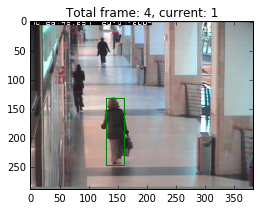

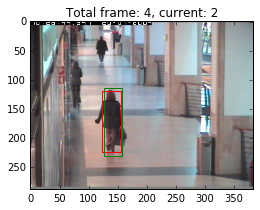

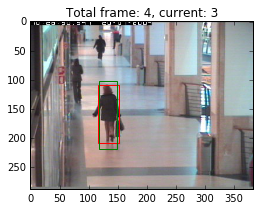

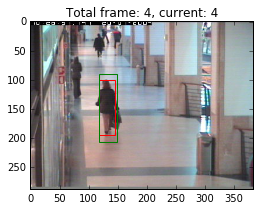

In [7]:
# visualize the result

print 'predit result (green box) and groundtruth (red box)'
while sequence._frame < len(sequence._images):
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    pd_rect = Rectangle(
            xy=(pos_list[sequence._frame][1], pos_list[sequence._frame][0]),
            width=scale_list[sequence._frame][1],
            height=scale_list[sequence._frame][0],
            facecolor='none',
            edgecolor='g',
    )
    plt.figure(figsize=(4,4))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    tracking_figure_axes.add_patch(pd_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence